### 📘 02_preprocessing.ipynb – Imputación y tratamiento de valores atípicos

Este notebook contiene el preprocesamiento del dataset de diabetes, incluyendo:

- Reemplazo de valores no válidos.
- Imputación de valores faltantes.
- Detección visual de outliers.
- Exportación del dataset limpio para uso posterior.

#### 1. Carga del dataset y configuración de librerías

Importamos las librerías necesarias y visualizamos las primeras filas del conjunto de datos.


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Estilo gráfico
sns.set(style="whitegrid")
%matplotlib inline

# Cargar el dataset limpio desde la ruta relativa
df = pd.read_csv("../data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 2. Detección de valores inválidos (ceros)

Algunas variables biométricas no pueden tener valores igual a cero. A continuación identificamos cuántos ceros hay en las columnas críticas.


In [45]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ver cuántos ceros hay en cada una
df[columns_with_zeros].eq(0).sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

### 3. Reemplazo de ceros por valores faltantes

Reemplazamos los ceros por `NaN` para poder imputarlos posteriormente.


In [46]:
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### 4. Imputación de valores faltantes usando mediana

La mediana es preferida porque es robusta ante valores extremos (outliers).


In [47]:
df[columns_with_zeros] = df[columns_with_zeros].fillna(df[columns_with_zeros].median())
df.isnull().sum()

# Verificar si los valores han sido reemplazados correctamente
df[columns_with_zeros].eq(0).sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

### 5. Visualización de posibles valores atípicos (outliers)

Usamos boxplots para detectar visualmente si existen valores atípicos en las variables.


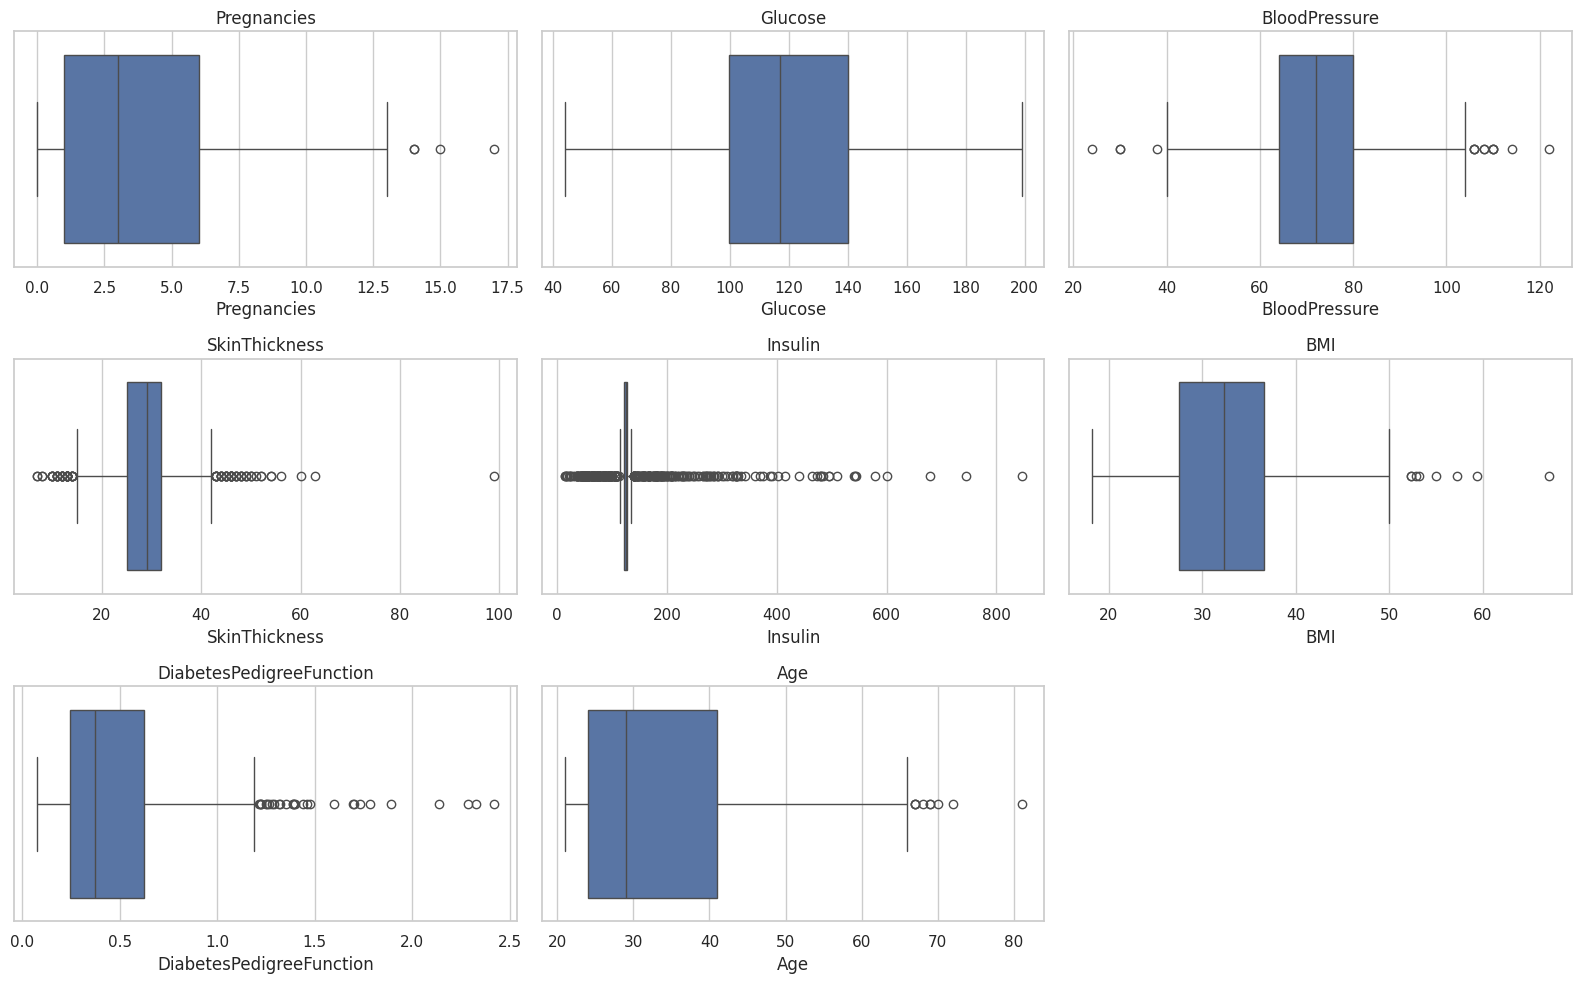

In [48]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


🎯 Tratamiento de outliers: Capping por percentiles

Durante el análisis exploratorio, se detectaron valores extremos (outliers) en algunas variables numéricas, como `Insulin` y `SkinThickness`, con valores muy superiores al rango típico de la población.

Se decidió aplicar **capping** por percentiles (también llamado recorte), que consiste en limitar los valores extremos a los percentiles 1% y 99%. Esta técnica presenta las siguientes ventajas en este caso:

- 🔹 **Preserva el tamaño del dataset**, lo cual es importante dado que solo se cuenta con 768 registros.
- 🔹 **Evita que los valores extremos sesguen el entrenamiento** de modelos sensibles como regresión logística o SVM.
- 🔹 **Es menos agresiva que eliminar datos**, lo que permite conservar patrones valiosos.

Las variables seleccionadas para capping fueron aquellas con mayor presencia de outliers detectados previamente.


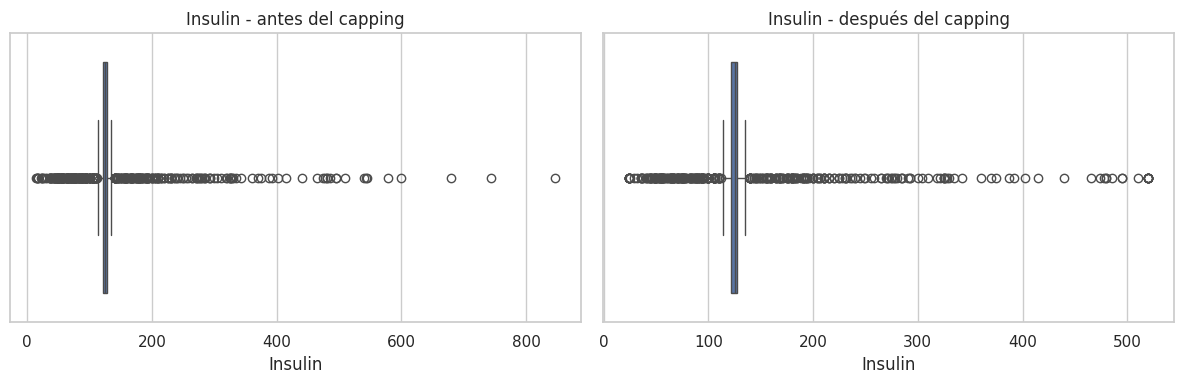

In [49]:
# Aplicación de capping (recorte) en variables con outliers

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['Insulin'], ax=axes[0])
axes[0].set_title("Insulin - antes del capping")

cols_to_cap = ['Insulin', 'SkinThickness', 'BloodPressure', 'BMI']

for col in cols_to_cap:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=q_low, upper=q_high)

sns.boxplot(x=df['Insulin'], ax=axes[1])
axes[1].set_title("Insulin - después del capping")
plt.tight_layout()
plt.show()

🧪 Efecto del capping en la variable `Insulin`

Como se observa en el boxplot, la aplicación de capping entre los percentiles 1% y 99% redujo notablemente la influencia de los valores atípicos extremos sin eliminar registros. Esto mejora la robustez de los modelos al tiempo que se conserva la información general del dataset.

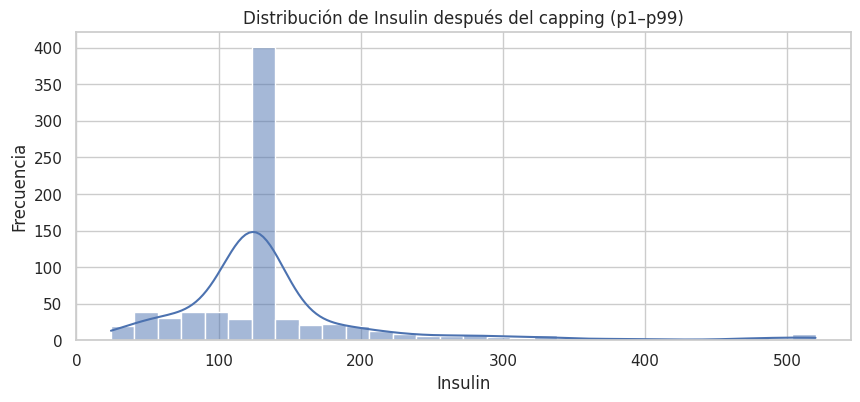

In [50]:
plt.figure(figsize=(10,4))
sns.histplot(df['Insulin'], bins=30, kde=True)
plt.title("Distribución de Insulin después del capping (p1–p99)")
plt.xlabel("Insulin")
plt.ylabel("Frecuencia")
plt.show()

🔁 Transformación de variables con alta asimetría

Algunas variables presentan una distribución altamente asimétrica, lo que puede afectar el desempeño de ciertos modelos sensibles a la escala y distribución. Usamos la métrica de skewness para identificar estas variables.

Transformamos las siguientes variables con `np.log1p(x)`:
- `Insulin`: skew = 2.67
- `DiabetesPedigreeFunction`: skew = 1.92

`log1p` es ideal para manejar valores cercanos a cero sin generar errores (log(0) es indefinido).


In [51]:
# Calcular skewness de todas las variables numéricas (excepto la variable objetivo)
skew_values = df.drop(columns='Outcome').skew().sort_values(ascending=False)
print(skew_values)

Insulin                     2.669974
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Pregnancies                 0.901674
Glucose                     0.535587
BMI                         0.375596
BloodPressure               0.189482
SkinThickness               0.150672
dtype: float64


In [52]:
df['Insulin'] = np.log1p(df['Insulin'])
df['DiabetesPedigreeFunction'] = np.log1p(df['DiabetesPedigreeFunction'])


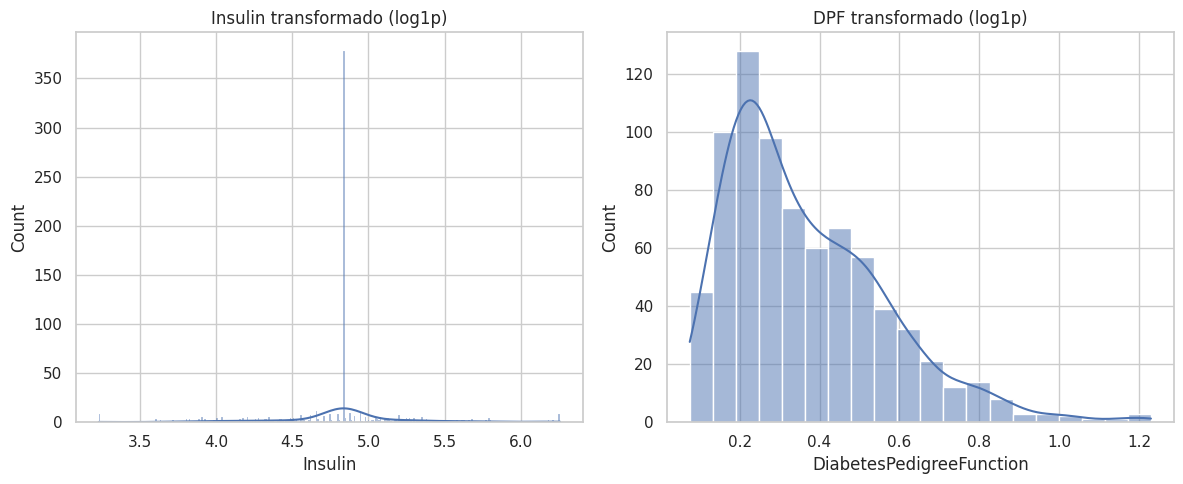

In [53]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Insulin'], kde=True, ax=axes[0])
axes[0].set_title('Insulin transformado (log1p)')
sns.histplot(df['DiabetesPedigreeFunction'], kde=True, ax=axes[1])
axes[1].set_title('DPF transformado (log1p)')
plt.tight_layout()
plt.show()

In [55]:
print(df[['Insulin', 'DiabetesPedigreeFunction']].skew())

Insulin                    -0.086189
DiabetesPedigreeFunction    1.117942
dtype: float64


Decidimos **no aplicar transformaciones adicionales** a la variable `DiabetesPedigreeFunction` ya que:

- La transformación logarítmica redujo su asimetría de ~1.92 a ~1.11.
- Esta asimetría es considerada aceptable para muchos modelos, especialmente aquellos que no se ven muy afectados por distribuciones no normales.


### 🔧 Escalado de Variables Numéricas

Para garantizar que los algoritmos de Machine Learning sensibles a la escala (como Regresión Logística o SVM) se comporten correctamente, se aplicó **escalado estándar (Z-score)** usando `StandardScaler` de `sklearn`.

Esto transforma cada variable para que tenga:
- **Media = 0**
- **Desviación estándar = 1**

In [56]:
# Columnas numéricas a escalar (ya imputadas y transformadas si aplica)
cols_to_scale = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [57]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


In [58]:
df_scaled[cols_to_scale].describe().T


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,-6.476301e-17,1.000652,-1.141852,-0.844885,-0.250952,0.639947,3.906578
Glucose,768.0,4.625929e-18,1.000652,-2.552931,-0.720163,-0.153073,0.611265,2.542658
BloodPressure,768.0,-1.156482e-17,1.000652,-2.429371,-0.719158,-0.035073,0.649012,2.872289
SkinThickness,768.0,2.844947e-16,1.000652,-2.293285,-0.484488,-0.002142,0.359618,2.690555
Insulin,768.0,-7.563394e-16,1.000652,-3.338972,-0.041702,0.017300,0.054326,2.987239
BMI,768.0,-1.087093e-16,1.000652,-1.937114,-0.736369,-0.015922,0.629478,2.754646
DiabetesPedigreeFunction,768.0,-1.156482e-16,1.000652,-1.462897,-0.741941,-0.245408,0.609734,4.356900
Age,768.0,1.931325e-16,1.000652,-1.041549,-0.786286,-0.360847,0.660206,4.063716


La operación se aplicó a las siguientes columnas:

- `Pregnancies`
- `Glucose`
- `BloodPressure`
- `SkinThickness`
- `Insulin` (después de log-transformación + capping)
- `BMI`
- `DiabetesPedigreeFunction`
- `Age`

📌 El resultado fue verificado mediante `df_scaled.describe()`, confirmando el escalado exitoso.


### 6. Distribución de variables imputadas

Visualizamos cómo quedaron distribuidas las variables después de la imputación.


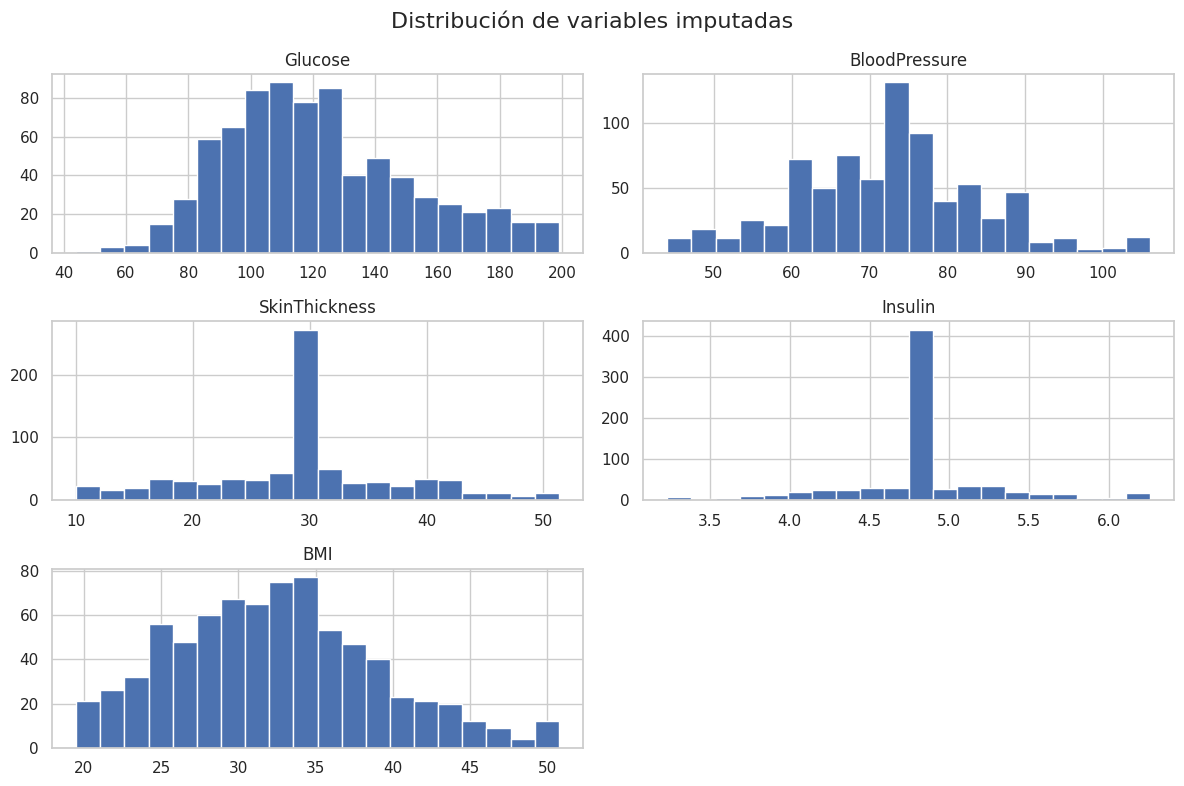

In [59]:
df[columns_with_zeros].hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribución de variables imputadas", fontsize=16)
plt.tight_layout()
plt.show()


### 7. Guardar el dataset limpio

Exportamos el nuevo dataset para usarlo en el siguiente paso de entrenamiento del modelo.


In [30]:
df.to_csv("../data/diabetes_clean.csv", index=False)
print("✅ Dataset limpio guardado como 'diabetes_clean.csv'")
# Verificar si el archivo se ha guardado correctamente
saved_df = pd.read_csv("../data/diabetes_clean.csv")
saved_df.head()

✅ Dataset limpio guardado como 'diabetes_clean.csv'


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin
0,6,148.0,72.0,35.0,33.6,0.627,50,1,1.764094
1,1,85.0,66.0,29.0,26.6,0.351,31,0,1.764094
2,8,183.0,64.0,29.0,23.3,0.672,32,1,1.764094
3,1,89.0,66.0,23.0,28.1,0.167,21,0,1.714496
4,0,137.0,44.0,35.0,43.1,2.288,33,1,1.813178


✅ Conclusión del Preprocesamiento

- Todos los ceros fisiológicamente imposibles fueron tratados como valores faltantes.
- Se aplicó imputación con la mediana, y se trató el outlier severo en `Insulin`.
- Variables con alta asimetría fueron transformadas con logaritmo.
- Se normalizaron todas las variables usando `StandardScaler`.
- El dataset limpio fue guardado en `data/diabetes_clean.csv` para usar en entrenamiento.
